In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import os

In [2]:
S = 64
SHOW = 64
STEP = 10
MAX_STEPS = 14
T = 1.0

h = 1/(S-1)
tau = h / ((1/3)**0.5 * 4.0)
at = np.pi

# Create coordinate arrays
x = np.linspace(0, 1, SHOW)
y = np.linspace(0, 1, SHOW)
z = np.linspace(0, 1, SHOW)

# Create meshgrids
X_y, Z_y = np.meshgrid(x, z, indexing='ij')
X_z, Y_z = np.meshgrid(x, y, indexing='ij')
Y_x, Z_x = np.meshgrid(y, z, indexing='ij')
plot_position = {'X': [1, 2, 3], 'Y': [4, 5, 6], 'Z': [7, 8, 9]}


PIPE_FILE = "/tmp/viz_pipe"

In [3]:
def read_command():
    """Read command from pipe file if available"""
    try:
        if os.path.exists(PIPE_FILE) and os.path.getsize(PIPE_FILE) > 0:
            with open(PIPE_FILE, 'r') as f:
                command = f.read().strip()

            open(PIPE_FILE, 'w').close()
            return command
    except Exception as e:
        print(f"Error reading command: {e}")
    return None

def parse_command(command):
    """Parse command in format x,y,z"""
    try:
        parts = command.split(',')
        if len(parts) == 3:
            x, y, z = map(int, parts)
            if all(0 <= val < S for val in [x, y, z]):
                return x, y, z
    except ValueError:
        pass
    return None

In [4]:
def create_slice_plots(fig, data, real_solution, fixed_dim, fixed_value):
    """Create 3 plots for a fixed dimension slice"""
    if fixed_dim == 'Y':
        data_slice = data[:SHOW, fixed_value, :SHOW]
        real_slice = real_solution
        X_plot, Y_plot = X_y, Z_y
        x_label, y_label = 'X', 'Z'
    elif fixed_dim == 'X':
        data_slice = data[fixed_value, :SHOW, :SHOW]
        real_slice = real_solution
        X_plot, Y_plot = Y_x, Z_x
        x_label, y_label = 'Y', 'Z'
    elif fixed_dim == 'Z':
        data_slice = data[:SHOW, :SHOW, fixed_value]
        real_slice = real_solution
        X_plot, Y_plot = X_z, Y_z
        x_label, y_label = 'X', 'Y'
    
    ax1 = fig.add_subplot(3, 3, plot_position[fixed_dim][0], projection='3d')
    surface1 = ax1.plot_surface(X_plot, Y_plot, data_slice)
    ax1.set_title(f'Data - Fixed {fixed_dim}={fixed_value}')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_zlim(-1, 1)
    
    ax2 = fig.add_subplot(3, 3, plot_position[fixed_dim][1], projection='3d')
    surface2 = ax2.plot_surface(X_plot, Y_plot, real_slice)
    ax2.set_title(f'Real - Fixed {fixed_dim}={fixed_value}')
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_zlim(-1, 1)
    
    ax3 = fig.add_subplot(3, 3, plot_position[fixed_dim][2], projection='3d')
    surface3 = ax3.plot_surface(X_plot, Y_plot, data_slice - real_slice)
    ax3.set_title(f'Diff - Fixed {fixed_dim}={fixed_value}')
    ax3.set_xlabel(x_label)
    ax3.set_ylabel(y_label)
    
    return data_slice, real_slice

In [5]:
def update_plot(fixed_x, fixed_y, fixed_z, time_step):
    
    data = np.fromfile(f'floats/floats{str(time_step)}0.bin', dtype=np.float32).reshape((S, S, S))
    
    fig = plt.figure(figsize=(20, 15))

    real_y = (np.sin(2*np.pi*X_y) * np.sin(np.pi*fixed_y*h+np.pi) * 
              np.sin(2*np.pi*Z_y+2*np.pi) * np.cos(at*time_step*tau*STEP+np.pi))
    real_x = (np.sin(2*np.pi*fixed_x*h) * np.sin(np.pi*Y_x+np.pi) * 
              np.sin(2*np.pi*Z_x+2*np.pi) * np.cos(at*time_step*tau*STEP+np.pi))
    real_z = (np.sin(2*np.pi*X_z) * np.sin(np.pi*Y_z+np.pi) * 
              np.sin(2*np.pi*fixed_z*h+2*np.pi) * np.cos(at*time_step*tau*STEP+np.pi))

    data_y, real_y_slice = create_slice_plots(fig, data, real_y, 'Y', fixed_y)
    data_x, real_x_slice = create_slice_plots(fig, data, real_x, 'X', fixed_x)
    data_z, real_z_slice = create_slice_plots(fig, data, real_z, 'Z', fixed_z)

    max_diff_y = np.max(np.abs(data_y - real_y_slice))
    max_diff_x = np.max(np.abs(data_x - real_x_slice))
    max_diff_z = np.max(np.abs(data_z - real_z_slice))

    plt.suptitle(f'Time step: {time_step} | Fixed: X={fixed_x}, Y={fixed_y}, Z={fixed_z} | '
                 f'Max differences - X:{max_diff_x:.8f}, Y:{max_diff_y:.8f}, Z:{max_diff_z:.8f}', 
                 fontsize=14)
    clear_output(wait=True)
    plt.tight_layout()
    plt.show()

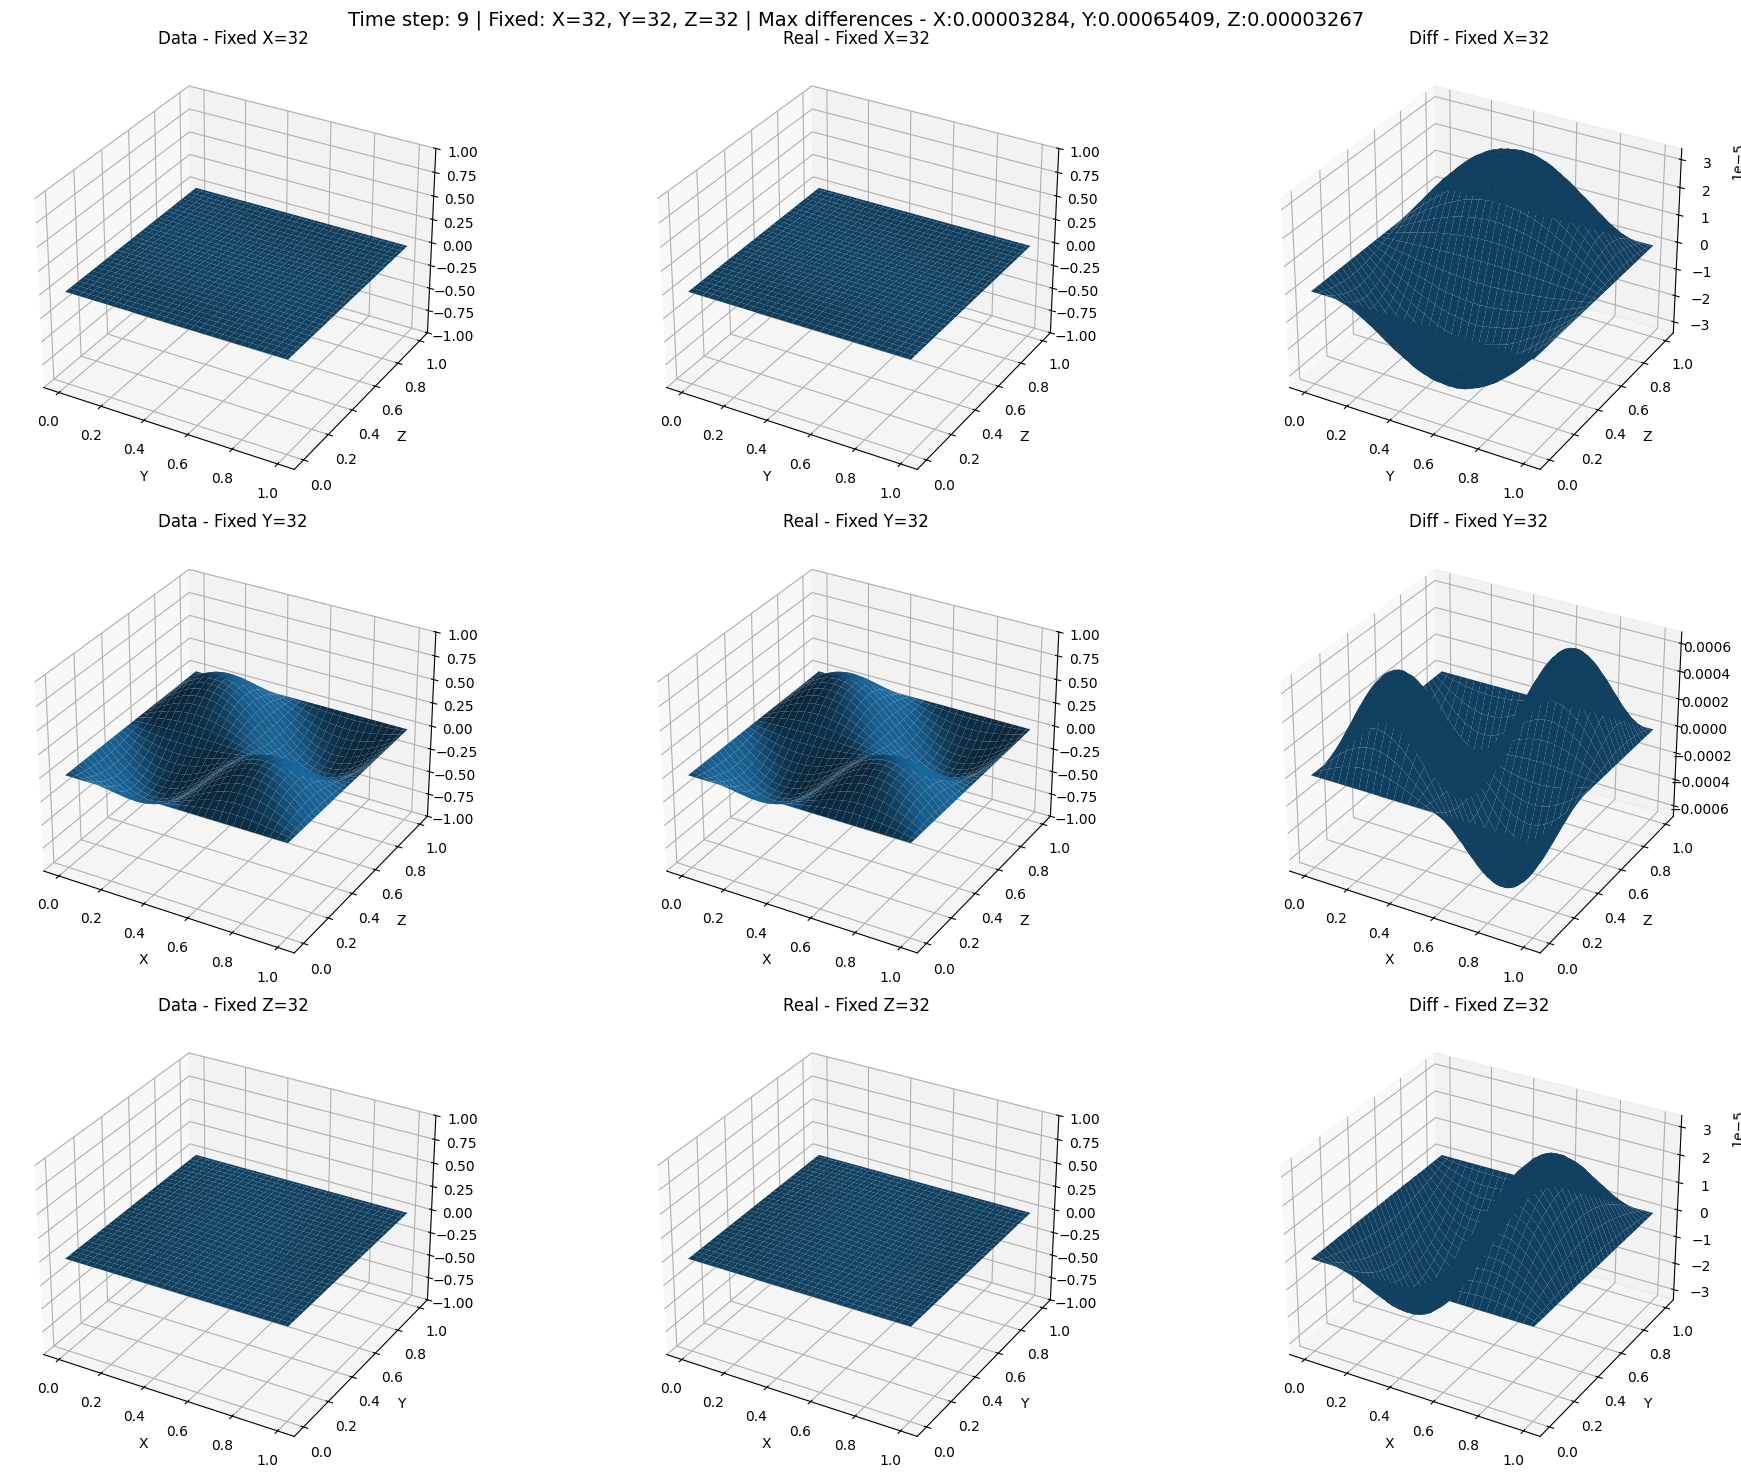

In [ ]:
time_step = 0
step = 1
fixed_x = S // 2
fixed_y = S // 2
fixed_z = S // 2

if not os.path.exists(PIPE_FILE):
    open(PIPE_FILE, 'w').close()

while True:
    command = read_command()
    if command:
        new_coords = parse_command(command)
        if new_coords:
            fixed_x, fixed_y, fixed_z = new_coords
            print(f"Command received: {command}")
            print(f"Updated to: X={fixed_x}, Y={fixed_y}, Z={fixed_z}")

    update_plot(fixed_x, fixed_y, fixed_z, time_step)

    time_step += step
    if time_step >= MAX_STEPS or time_step <= 0:
        step *= -1
        time_step = max(0, min(time_step, MAX_STEPS))
    
    time.sleep(0.5)